# Purpose and significance

## Background

The nifH gene is an important marker gene for studying biological nitrogen fixation function. By analyzing the sequence characteristics of the gene (such as GC content, sequence length, etc.), its functional activity or abundance can be evaluated. This is of great significance for understanding the nitrogen cycle in marine ecosystems.

## Research purpose

1. Explore the relationship between the key characteristics and functional activity of the nifH gene.

2. Use machine learning models (linear regression, random forest, neural network) to predict the nitrogen fixation function of unknown samples.

3. Compare the performance of different models and evaluate their applicability in bioinformatics analysis.

## Significance

By introducing the model method, it is possible to:

1. Improve the accuracy of nitrogen fixation gene function prediction and expand its application scenarios.

2. Capture complex feature relationships and provide references for future gene function research.

3. Build a general analysis framework to provide methodological support for other gene function analyses.


## ID: Unique identifier of the gene sequence.

## Sequence: The base sequence of the gene (A, T, C, G).

## Length: The length of the gene in base pairs.

## GC_Content: GC content, which is (G + C) / total length.


In [44]:
import sys
print(sys.version)

3.9.18 (main, Sep 11 2023, 08:38:23) 
[Clang 14.0.6 ]


In [45]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score ,classification_report,ConfusionMatrixDisplay
from collections import Counter
from Bio import SeqIO
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


<!-- 是一个典型的 nifH 基因序列长度范围，GC 含量为 0.646，符合固氮基因常见的高 GC 含量特性。 -->


In [46]:
# Define the master data folder path
# 定义主数据文件夹路径
data_folder = "./nifHdata"

# Stores a list of all sequences
# 存储所有序列的列表
all_sequences = []

# Tags, tags for each genome
# 标签，每个基因组的标签
all_labels = []

all_annotations = []  # 存储注释信息

In [47]:
# Traverse 20 folders
# 遍历20个文件夹
for i in range(20):
    folder_name = f"nifH_datasets ({i})" if i > 0 else "nifH_datasets"
    folder_path = os.path.join(data_folder, folder_name)
    gene_file = os.path.join(folder_path, "ncbi_dataset/data/gene.fna")
    
    # Make sure the file exists
    # 确保文件存在
    if os.path.exists(gene_file):
        # Read sequence and annotation information from fasta files
        # 读取 fasta 文件中的序列和注释信息
        for record in SeqIO.parse(gene_file, "fasta"):
            all_sequences.append(str(record.seq))  # 转换为字符串存储
            all_annotations.append(record.description)  # 存储注释信息
            all_labels.append(i)  # 标签对应文件夹编号
    else:
        print(f"can not find file：{gene_file}")


# 打印结果
print(f"successfully load {len(all_sequences)} sequence！")
print(f"total {len(set(all_labels))} categories, the labeled are{set(all_labels)}")
print("Example sequence:", all_sequences[0][:50], "...")  # 只显示第一条序列前 50 个字符
print("Example annotation:", all_annotations[0])  # 显示第一条序列的注释信息
print("Example tags:", all_labels[0])  # 显示第一条序列的标签


successfully load 20 sequence！
total 20 categories, the labeled are{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Example sequence: ATGTCTTTGCGCCAGATTGCGTTCTACGGTAAGGGCGGTATCGGCAAGTC ...
Example annotation: NZ_VISK01000015.1:262164-263045 nifH [organism=Azospirillum brasilense] [GeneID=56451760] [chromosome=]
Example tags: 0


In [48]:
print(all_sequences)

['ATGTCTTTGCGCCAGATTGCGTTCTACGGTAAGGGCGGTATCGGCAAGTCCACCACCTCCCAGAACACCCTGGCCGCGCTGGTCGAGCTGGATCAGAAGATCCTGATCGTCGGCTGCGATCCGAAGGCCGACTCGACCCGCCTGATCCTGCACGCCAAGGCGCAGGACACCGTGCTGCACCTCGCCGCCGAAGCCGGCTCGGTCGAGGATCTGGAGCTCGAGGACGTTCTCAAGATCGGCTACAAGGGCATCAAGTGCGTCGAGTCCGGCGGTCCGGAGCCGGGGGTCGGCTGCGCCGGCCGCGGCGTGATCACCTCGATCAACTTCCTGGAAGAGAACGGCGCCTACGACGACGTGGACTACGTCTCCTACGACGTGCTGGGCGACGTGGTGTGCGGCGGTTTCGCCATGCCCATCCGCGAGAACAAGGCCCAGGAAATCTACATCGTCATGTCCGGTGAGATGATGGCGCTCTACGCCGCCAACAACATCGCCAAGGGCATTCTGAAGTACGCCCACAGCGGCGGCGTGCGCCTCGGCGGCCTGATCTGCAACGAGCGCCAGACCGACAAGGAAATCGACCTCGCCTCCGCCCTGGCCGCCCGCCTCGGCACCCAGCTCATCCACTTCGTGCCGCGCGACAACATCGTGCAGCACGCCGAGCTGCGCCGCATGACGGTGATCGAGTACGCGCCGGACAGCCAGCAGGCCCAGGAATACCGCCAGCTCGCCAACAAGGTCCACGCGAACAAGGGCAAGGGCACCATCCCGACCCCGATCACGATGGAAGAGCTGGAAGAGATGCTGATGGACTTCGGCATCATGAAGTCGGAGGAGCAGCAGCTCGCCGAGCTCCAGGCCAAGGAAGCCGCCAAGGCCTGA', 'ATGAGACAGGTAGCAATATATGGAAAAGGCGGTATAGGAAAATCCACTACAACCCAGAACACGGTGGCAGCGTTGGCCGAAGCAGGAAAAAAGGTCATGGTGGTAGGATGCG

In [49]:
# Print each sequence, one per line
# 打印每条序列，每行一条
for idx, sequence in enumerate(all_sequences):
    print(f"sample {idx + 1}:\n{sequence}\n")


sample 1:
ATGTCTTTGCGCCAGATTGCGTTCTACGGTAAGGGCGGTATCGGCAAGTCCACCACCTCCCAGAACACCCTGGCCGCGCTGGTCGAGCTGGATCAGAAGATCCTGATCGTCGGCTGCGATCCGAAGGCCGACTCGACCCGCCTGATCCTGCACGCCAAGGCGCAGGACACCGTGCTGCACCTCGCCGCCGAAGCCGGCTCGGTCGAGGATCTGGAGCTCGAGGACGTTCTCAAGATCGGCTACAAGGGCATCAAGTGCGTCGAGTCCGGCGGTCCGGAGCCGGGGGTCGGCTGCGCCGGCCGCGGCGTGATCACCTCGATCAACTTCCTGGAAGAGAACGGCGCCTACGACGACGTGGACTACGTCTCCTACGACGTGCTGGGCGACGTGGTGTGCGGCGGTTTCGCCATGCCCATCCGCGAGAACAAGGCCCAGGAAATCTACATCGTCATGTCCGGTGAGATGATGGCGCTCTACGCCGCCAACAACATCGCCAAGGGCATTCTGAAGTACGCCCACAGCGGCGGCGTGCGCCTCGGCGGCCTGATCTGCAACGAGCGCCAGACCGACAAGGAAATCGACCTCGCCTCCGCCCTGGCCGCCCGCCTCGGCACCCAGCTCATCCACTTCGTGCCGCGCGACAACATCGTGCAGCACGCCGAGCTGCGCCGCATGACGGTGATCGAGTACGCGCCGGACAGCCAGCAGGCCCAGGAATACCGCCAGCTCGCCAACAAGGTCCACGCGAACAAGGGCAAGGGCACCATCCCGACCCCGATCACGATGGAAGAGCTGGAAGAGATGCTGATGGACTTCGGCATCATGAAGTCGGAGGAGCAGCAGCTCGCCGAGCTCCAGGCCAAGGAAGCCGCCAAGGCCTGA

sample 2:
ATGAGACAGGTAGCAATATATGGAAAAGGCGGTATAGGAAAATCCACTACAACCCAGAACACGGTGGCAGCGTTGGCCGAAGCAGGAAAAAAGGTC

In [50]:
# Write all sequences to a file
# define the output file name
output_file = "sequences_output.dat"

with open(output_file, "w") as f:
    for idx, sequence in enumerate(all_sequences):
        f.write(f"sample {idx + 1}:\n{sequence}\n\n")

print(f"all the sequence have saved into: {output_file}")

all the sequence have saved into: sequences_output.dat


# Directly convert these original sequences into One-hot encoding

### The main reason for converting the original sequence into one-hot encoding is to represent the gene sequence in a numerical form that can be understood by computers while retaining biological information.

The original gene sequence is composed of characters (such as A, T, G, C, etc.), which cannot be processed directly by computers. Before modeling, these characters need to be converted into numerical form, and One-hot encoding is a common representation method that can retain the information of each base in the original sequence.


In [51]:
import numpy as np

# 定义 One-hot 编码函数
def one_hot_encode(seq, max_length):
    mapping = {'A': 0, 'T': 1, 'G': 2, 'C': 3, 'N': 4}  # 碱基映射
    one_hot = np.zeros((max_length, len(mapping)), dtype=np.float32)
    for i, char in enumerate(seq[:max_length]):  # 限制最大长度
        if char in mapping:
            one_hot[i, mapping[char]] = 1
    return one_hot

# Calculate the length of each sequence （计算每条序列的长度）


In [52]:

# 获取所有序列的最大长度
max_length = max(len(seq) for seq in all_sequences)

# 转换所有序列为 One-hot 编码
encoded_sequences = np.array([one_hot_encode(seq, max_length) for seq in all_sequences])
encoded_labels = np.array(all_labels, dtype=np.int32)

# 打印编码结果
print(f"One-hot Coding is complete! Total number of samples:{encoded_sequences.shape[0]}")  # 样本数 编码完成！总样本数：20
print(f"The encoding shape of each sequence is:{encoded_sequences.shape[1:]}")  # 例如 (max_length, 5) 每条序列的编码形状：(894, 5)
print(f"Label shape:{encoded_labels.shape}")  # 标签形状：(20,)


One-hot Coding is complete! Total number of samples:20
The encoding shape of each sequence is:(894, 5)
Label shape:(20,)


In [53]:
from sklearn.model_selection import train_test_split

# 划分数据集
train_data, test_data, train_labels, test_labels = train_test_split(
    encoded_sequences, encoded_labels, test_size=0.2, random_state=42
)

# 打印数据划分结果
print(f"Number of training set samples:{train_data.shape[0]}")  #训练集样本数：16
print(f"Number of test set samples:{test_data.shape[0]}")       #测试集样本数：4
print(f"The shape of each sequence is:{train_data.shape[1:]}")        #每条序列的形状：(894, 5)
print(f"Label shape: Training set:{train_labels.shape}, test set:{test_labels.shape}")       #标签形状：训练集：(16,)，测试集：(4,)


Number of training set samples:16
Number of test set samples:4
The shape of each sequence is:(894, 5)
Label shape: Training set:(16,), test set:(4,)


In [54]:
from Bio.Seq import Seq

# 送检序列
query_sequence = Seq("""
CTCCACTCGTCTGCTGCTCGGTGGACTGGCCCAGAAATCTGTACTTGATACTCTGCGGGAAGAAGGTGAGGACGTTGAACTCGACGATATCAGAAAAGCAGCTTACGGAGGAACCTGGGCAGTTGAATCAGGTGGCCCGGAGCCGGGTGTTGGCTGTGCAGGCCGAGGTATCATAACCGCGATTAACATGCTTGAATCCCTTGGCGCCTATGAGGAGAGCGAAAGCCTTGACTACGCCTTCTATGATGTTCTCGGTGATGTTGTTTGCGGTGGTTTTGCCATGCCCATCAGAGATGGTAAGGCGGAAGAAATCTATATCGTTGTCTCA
""".strip())

# 20 个样本序列
# print(all_sequences)

# 最小匹配长度
min_length = 11

def find_and_count_repeats(query_sequence, reference_sequences, min_length=5):
    """
    统计送检序列与参考序列之间的匹配片段数量，并返回匹配片段
    :param query_sequence: 送检序列
    :param reference_sequences: 参考序列列表
    :param min_length: 每次截取的长度（默认为 5）
    :return: 每个参考序列匹配片段的数量和匹配的片段列表
    """
    # 结果存储每个样本的匹配数量和匹配片段
    match_details = []

    # 遍历每个参考序列
    for ref_idx, reference_sequence in enumerate(reference_sequences):
        match_count = 0
        matched_fragments = set()  # 使用集合避免重复记录相同片段

        # 遍历送检序列，以步长为 1 滑动窗口截取 min_length 长度的片段
        for i in range(len(query_sequence) - min_length + 1):
            query_fragment = str(query_sequence[i:i + min_length])  # 将片段转换为字符串
            
            # 如果片段在参考序列中，记录匹配
            if query_fragment in reference_sequence:
                match_count += 1
                matched_fragments.add(query_fragment)

        # 保存匹配数量和匹配片段
        match_details.append((match_count, list(matched_fragments)))

    return match_details

# 调用函数计算匹配数量和片段
results = find_and_count_repeats(query_sequence, all_sequences, min_length=min_length)

# 打印结果
for idx, (count, fragments) in enumerate(results):
    print(f"sample {idx} The number of long continuous matching fragments with the submitted sequence:{count}")        #样本 0 与送检序列的长连续匹配片段数量：3
    if fragments:
        print(f"Matching fragments:{', '.join(fragments)}")      #匹配片段：GTTGTTGCGGT, GGTGGTTTTGC, GGTGGTTTTGC
    else:
        print("No matching fragments.")     #没有匹配片段。

sample 0 The number of long continuous matching fragments with the submitted sequence:3
Matching fragments:GCCATGCCCAT, CCATGCCCATC, CCGGAGCCGGG
sample 1 The number of long continuous matching fragments with the submitted sequence:2
Matching fragments:GCCATGCCCAT, CCATGCCCATC
sample 2 The number of long continuous matching fragments with the submitted sequence:4
Matching fragments:TCTATATCGTT, CTATATCGTTG, ATCTATATCGT, GGCTGTGCAGG
sample 3 The number of long continuous matching fragments with the submitted sequence:1
Matching fragments:TGCGGTGGTTT
sample 4 The number of long continuous matching fragments with the submitted sequence:5
Matching fragments:TTTTGCCATGC, GTTTTGCCATG, TTTGCCATGCC, CTCGGTGATGT, GGTTTTGCCAT
sample 5 The number of long continuous matching fragments with the submitted sequence:1
Matching fragments:GGTGGTTTTGC
sample 6 The number of long continuous matching fragments with the submitted sequence:2
Matching fragments:GGCGCCTATGA, CCGGAGCCGGG
sample 7 The number of l

In [55]:

# 计算特征函数
def calculate_features(sequence):
    # ATCG 所占比例
    length = len(sequence)
    A_ratio = sequence.count('A') / length
    T_ratio = sequence.count('T') / length
    C_ratio = sequence.count('C') / length
    G_ratio = sequence.count('G') / length

    # GC含量
    gc_content = (sequence.count('G') + sequence.count('C')) / length

    # 大于 4 个碱基长度的连续重复序列数
    long_repeats_count = sum(1 for i in range(len(sequence) - 4) if sequence[i:i + 5] == sequence[i] * 5)

    # 序列熵（香农熵）
    base_counts = [sequence.count(base) / length for base in "ATCG"]
    seq_entropy = entropy(base_counts)

    # 最长碱基重复长度
    max_repeat_length = max(len(list(g)) for _, g in groupby(sequence))

    return {
        "A_Ratio": A_ratio,
        "T_Ratio": T_ratio,
        "C_Ratio": C_ratio,
        "G_Ratio": G_ratio,
        "GC_Content": gc_content,
        "Long_Repeats_Count": long_repeats_count,
        "Sequence_Entropy": seq_entropy,
        "Max_Repeat_Length": max_repeat_length
    }


In [56]:
def calculate_gc_content(sequence):
    """手动计算GC含量比例"""
    counts = Counter(sequence)
    g, c = counts['G'], counts['C']
    return ((g + c) / sum(counts.values())) * 100

def calculate_at_bias(sequence):
    """计算A/T偏向值"""
    counts = Counter(sequence)
    a, t = counts['A'], counts['T']
    return abs(a - t) / sum(counts.values())

def count_continuous_repeats(sequence):
    """计算 A/T/C/G 连续重复 3 次及以上的比例，返回每种碱基的比例和最大连续重复次数"""
    repeat_counts = {"A": 0, "T": 0, "C": 0, "G": 0}
    max_repeats = {"A": 0, "T": 0, "C": 0, "G": 0}
    total_length = len(sequence)
    
    for base in repeat_counts.keys():
        # 创建滑动窗口统计重复次数
        count = 0
        max_count = 0
        
        for char in sequence:
            if char == base:
                count += 1
                max_count = max(max_count, count)  # 更新最大连续重复次数
            else:
                count = 0
        
        repeat_counts[base] = sum(1 for i in range(len(sequence) - 2) if sequence[i:i + 3] == base * 3)
        max_repeats[base] = max_count  # 保存最大重复次数

    repeat_ratios = {base: repeat_counts[base] / total_length for base in repeat_counts.keys()}

    return repeat_ratios, max_repeats


def calculate_entropy(sequence):
    """计算香农熵"""
    counts = Counter(sequence)
    total = sum(counts.values())
    probabilities = [count / total for count in counts.values()]
    return -sum(p * math.log2(p) for p in probabilities)

# 创建数据表存储结果
results = []


for idx, seq in enumerate(all_sequences):
    gc_content = calculate_gc_content(seq)
    at_bias = calculate_at_bias(seq)
    
    # 获取重复比例和最大重复次数
    repeat_ratios, max_repeats = count_continuous_repeats(seq)  
    
    entropy = calculate_entropy(seq)

    results.append({
        "Sample": idx + 1,
        "GC Content (%)": gc_content,
        "A/T Bias": at_bias,
        "A Repeat Ratio": repeat_ratios["A"],  # 添加 A 重复比例
        "T Repeat Ratio": repeat_ratios["T"],  # 添加 T 重复比例
        "C Repeat Ratio": repeat_ratios["C"],  # 添加 C 重复比例
        "G Repeat Ratio": repeat_ratios["G"],  # 添加 G 重复比例
        "Max A Repeat": max_repeats["A"],  # 添加 A 最大重复次数
        "Max T Repeat": max_repeats["T"],  # 添加 T 最大重复次数
        "Max C Repeat": max_repeats["C"],  # 添加 C 最大重复次数
        "Max G Repeat": max_repeats["G"],  # 添加 G 最大重复次数
        "Entropy": entropy
    })
# GC 含量
# A/T 偏向值
# A/T/C/G 的重复比例
# A/T/C/G 的最大连续重复次数
# 香农熵



# 转换为数据框
df = pd.DataFrame(results)

# 展示数据表
df

,Sample,GC Content (%),A/T Bias,A Repeat Ratio,T Repeat Ratio,C Repeat Ratio,G Repeat Ratio,Max A Repeat,Max T Repeat,Max C Repeat,Max G Repeat,Entropy
0,1,64.625850,0.061224,0.002268,0.002268,0.014739,0.010204,3,3,4,5,1.928988
1,2,56.166056,0.101343,0.020757,0.006105,0.013431,0.021978,6,4,4,5,1.968234
2,3,52.798054,0.068127,0.008516,0.008516,0.008516,0.012165,3,4,4,5,1.990420
3,4,61.696970,0.080000,0.009697,0.002424,0.019394,0.019394,4,3,4,3,1.945121
4,5,56.438026,0.048135,0.022864,0.008424,0.015644,0.018051,5,4,4,5,1.983183
5,6,45.454545,0.017957,0.029181,0.015713,0.011223,0.002245,5,4,4,3,1.993602
6,7,56.712963,0.069444,0.032407,0.017361,0.006944,0.013889,6,4,3,5,1.976424
7,8,55.477855,0.037296,0.025641,0.016317,0.012821,0.015152,5,4,4,4,1.985325
8,9,58.053691,0.054810,0.015660,0.004474,0.011186,0.020134,4,3,6,6,1.975983
9,10,46.125461,0.017220,0.034440,0.023370,0.003690,0.009840,7,4,4,4,1.982577


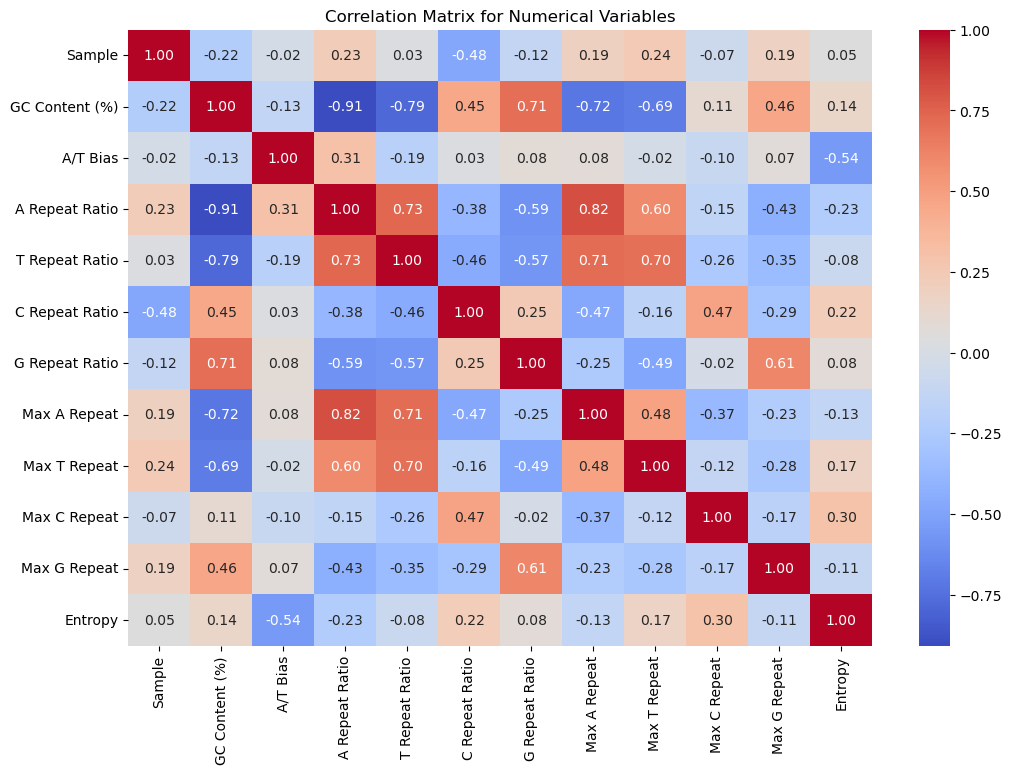

In [57]:
# 选择数值型列进行相关性分析
numeric_data = df.select_dtypes(include=[np.number])

# 计算相关性矩阵
correlation_matrix = numeric_data.corr()

# 绘制相关性矩阵热图
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numerical Variables')
plt.show()

In [58]:
print(df.columns)

Index(['Sample', 'GC Content (%)', 'A/T Bias', 'A Repeat Ratio',
       'T Repeat Ratio', 'C Repeat Ratio', 'G Repeat Ratio', 'Max A Repeat',
       'Max T Repeat', 'Max C Repeat', 'Max G Repeat', 'Entropy'],
      dtype='object')


GC Content (%)
High      11
Medium     6
Low        3
Name: count, dtype: int64


/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters: {'rf__max_depth': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
              precision    recall  f1-score   support

        High       0.67      1.00      0.80         2
         Low       1.00      1.00      1.00         1
      Medium       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.56      0.67      0.60         4
weighted avg       0.58      0.75      0.65         4



/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

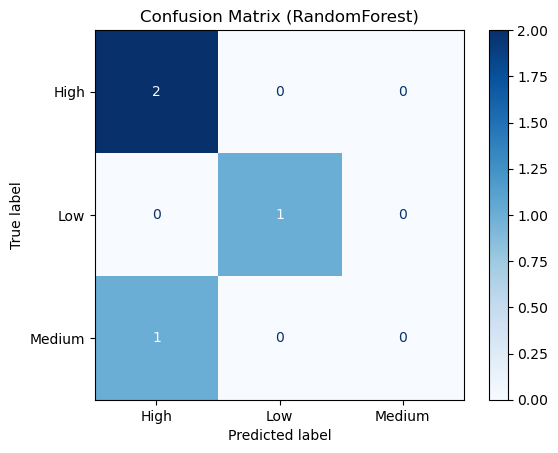

In [59]:
# 特征和目标
X = df.drop(columns=['Sample'])  # 去掉样本编号列
y = pd.cut(df['GC Content (%)'], bins=3, labels=["Low", "Medium", "High"])  # 通过GC含量分成3类

# 检查新目标变量的类别分布
print(y.value_counts())

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define pipeline with scaling and RandomForest
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('rf', RandomForestClassifier(random_state=42))  
])

# Define hyperparameter grid for RandomForest
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 20, None],
    'rf__min_samples_split': [2, 5, 10]
}

# Use GridSearchCV for hyperparameter tuning
rf_grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)

# Best parameters
best_params = rf_grid.best_params_
print(f"Best Parameters: {best_params}")

# Predict on test set
y_pred = rf_grid.best_estimator_.predict(X_test)

# 输出分类报告
print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
ConfusionMatrixDisplay.from_estimator(rf_grid, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix (RandomForest)')
plt.show()


In [60]:
print(df.head())

   Sample  GC Content (%)  A/T Bias  A Repeat Ratio  T Repeat Ratio  \
0       1       64.625850  0.061224        0.002268        0.002268   
1       2       56.166056  0.101343        0.020757        0.006105   
2       3       52.798054  0.068127        0.008516        0.008516   
3       4       61.696970  0.080000        0.009697        0.002424   
4       5       56.438026  0.048135        0.022864        0.008424   

   C Repeat Ratio  G Repeat Ratio  Max A Repeat  Max T Repeat  Max C Repeat  \
0        0.014739        0.010204             3             3             4   
1        0.013431        0.021978             6             4             4   
2        0.008516        0.012165             3             4             4   
3        0.019394        0.019394             4             3             4   
4        0.015644        0.018051             5             4             4   

   Max G Repeat   Entropy  
0             5  1.928988  
1             5  1.968234  
2             

# model


## 1 Lasso Regression model


In [62]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a pipeline: scaling + Lasso Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('lasso', Lasso(max_iter=10000))  
])

# Define the hyperparameter grid for alpha
param_grid = {
    'lasso__alpha': [0.01, 0.1, 1, 10, 50, 100]
}

# Set up GridSearchCV for hyperparameter tuning
lasso_grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

# Best alpha value
best_alpha = lasso_grid.best_params_['lasso__alpha']
print(f"Best Alpha (Regularization Strength): {best_alpha}")

# Predict on the test set using the best Lasso model
y_pred = lasso_grid.best_estimator_.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse_lasso = np.sqrt(mse)
r2_lasso = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse_lasso:.4f}")
print(f"R² Score: {r2_lasso:.4f}")

# Scatter plot: Actual vs Predicted for Lasso Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b', label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit (y=x)")
plt.title('Actual vs Predicted (Lasso Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

# Plot: Actual vs Predicted values 
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", color="red", alpha=0.7, linewidth=1.5)
plt.plot(range(len(y_pred)), y_pred, label="Predicted", color="blue", alpha=0.7, linewidth=1.5)
plt.title("Testing Data: Actual vs Predicted Values (Lasso Regression)")
plt.xlabel("Index")
plt.ylabel("Target Variable")
plt.legend()
plt.grid()
plt.show()


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py", line 905, in fit
    X, y = self._validate_data(
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1162, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1187, in _check_y
    y = y.astype(np.float64)
ValueError: could not convert string to float: 'Low'

--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py", line 905, in fit
    X, y = self._validate_data(
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1162, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1187, in _check_y
    y = y.astype(np.float64)
ValueError: could not convert string to float: 'Medium'


## 2 Ridge Regression


RMSE: 6.8260
R^2: -0.1123


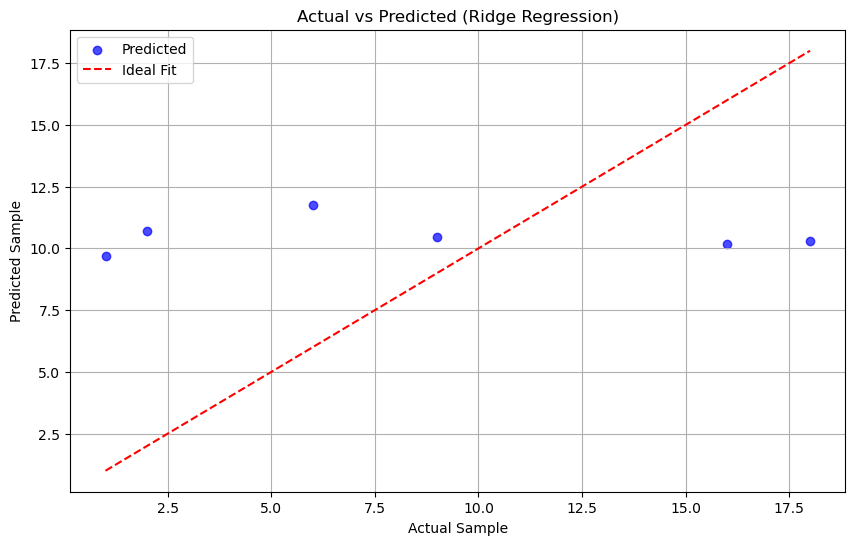

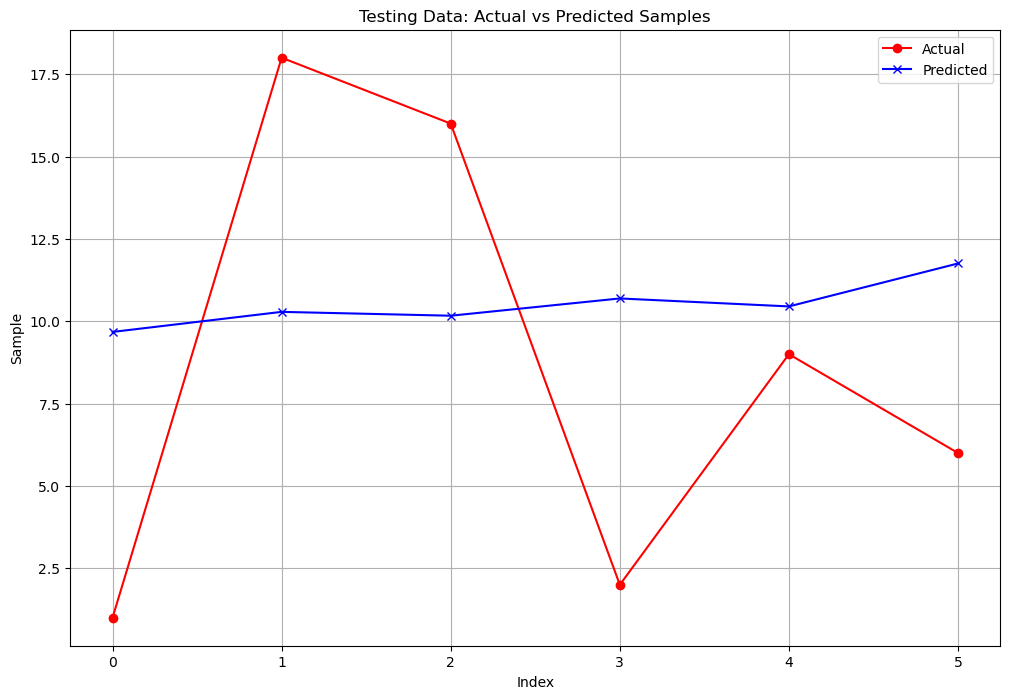

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 特征和目标
X = df.drop(columns=['Sample'])
y = df['Sample']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# test size 0.2：就是剩余80%训练，20参加测试

# 模型初始化
ridge = Ridge(alpha=500)  # 使用 alpha=500
ridge.fit(X_train, y_train)

# 预测
y_pred = ridge.predict(X_test)

# 计算 RMSE 和 R^2
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

# 绘制实际值与预测值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.title('Actual vs Predicted (Ridge Regression)')
plt.xlabel('Actual Sample')
plt.ylabel('Predicted Sample')
plt.legend()
plt.grid()
plt.show()

# 折线图：实际值与预测值
plt.figure(figsize=(12, 8))
plt.plot(range(len(y_test)), y_test, label='Actual', color='red', marker='o')
plt.plot(range(len(y_pred)), y_pred, label='Predicted', color='blue', marker='x')
plt.title('Testing Data: Actual vs Predicted Samples')
plt.xlabel('Index')
plt.ylabel('Sample')
plt.legend()
plt.grid()
plt.show()


## 3 Randon Forest


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'model__max_depth': None, 'model__n_estimators': 200}
Random Forest Regressor (GridSearchCV) - RMSE: 6.1166, R^2 Score: 0.1069


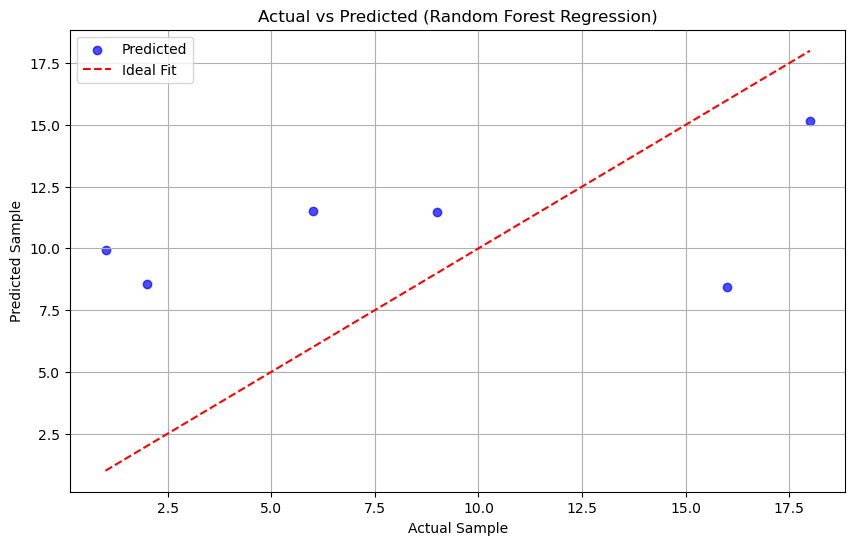

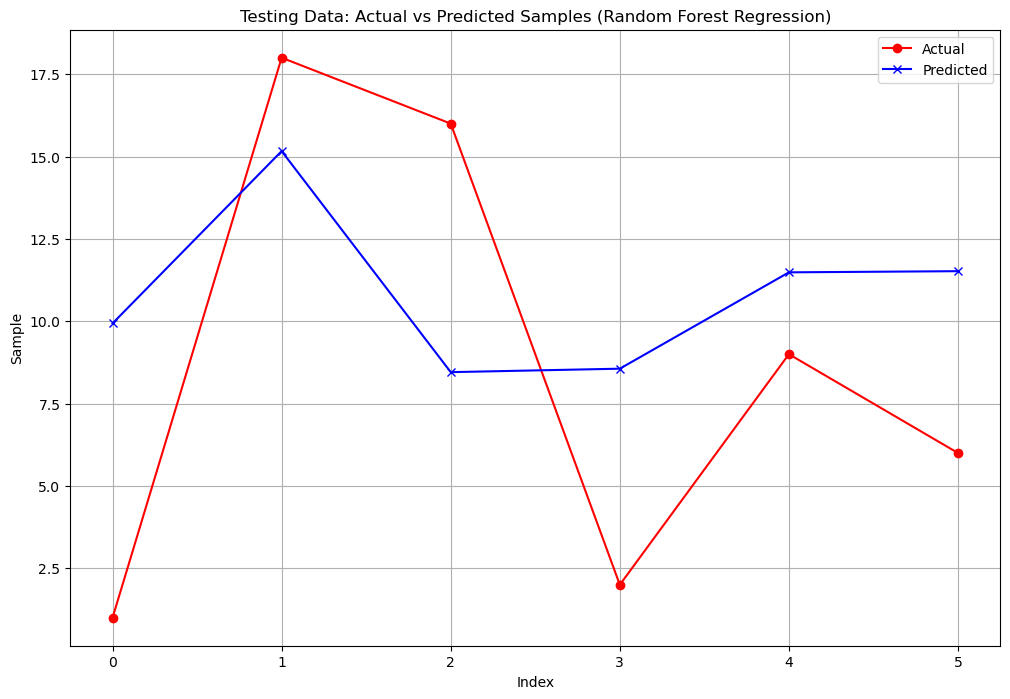

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# 特征和目标
X = df.drop(columns=['Sample'])
y = df['Sample']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 定义参数网格
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30]
}

# 创建带有缩放和随机森林的管道
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('model', RandomForestRegressor(random_state=42))  
])

# 使用 GridSearchCV 进行超参数调优
rf_grid_search = GridSearchCV(
    rf_pipeline, 
    param_grid=param_grid_rf, 
    cv=3,  
    scoring='neg_mean_squared_error',  
    verbose=1,  
    n_jobs=1  
)

# 在训练数据上拟合 GridSearchCV
rf_grid_search.fit(X_train, y_train)

# 提取最佳模型
best_rf_model = rf_grid_search.best_estimator_

# 在测试集上进行预测
y_pred_rf = best_rf_model.predict(X_test)

# 计算评估指标
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Best Parameters: {rf_grid_search.best_params_}")
print(f"Random Forest Regressor (GridSearchCV) - RMSE: {rmse_rf:.4f}, R^2 Score: {r2_rf:.4f}")

# 绘制实际值与预测值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color='b', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.title('Actual vs Predicted (Random Forest Regression)')
plt.xlabel('Actual Sample')
plt.ylabel('Predicted Sample')
plt.legend()
plt.grid()
plt.show()

# 折线图：实际值与预测值
plt.figure(figsize=(12, 8))
plt.plot(range(len(y_test)), y_test, label='Actual', color='red', marker='o')
plt.plot(range(len(y_pred_rf)), y_pred_rf, label='Predicted', color='blue', marker='x')
plt.title('Testing Data: Actual vs Predicted Samples (Random Forest Regression)')
plt.xlabel('Index')
plt.ylabel('Sample')
plt.legend()
plt.grid()
plt.show()


我很想知道这是什么参数会更加重要，所以我引入了：GridSearchCV


Best Parameters: {'model__max_depth': None, 'model__n_estimators': 200}
Random Forest Regressor (GridSearchCV) - RMSE: 6.1166, R² Score: 0.1069


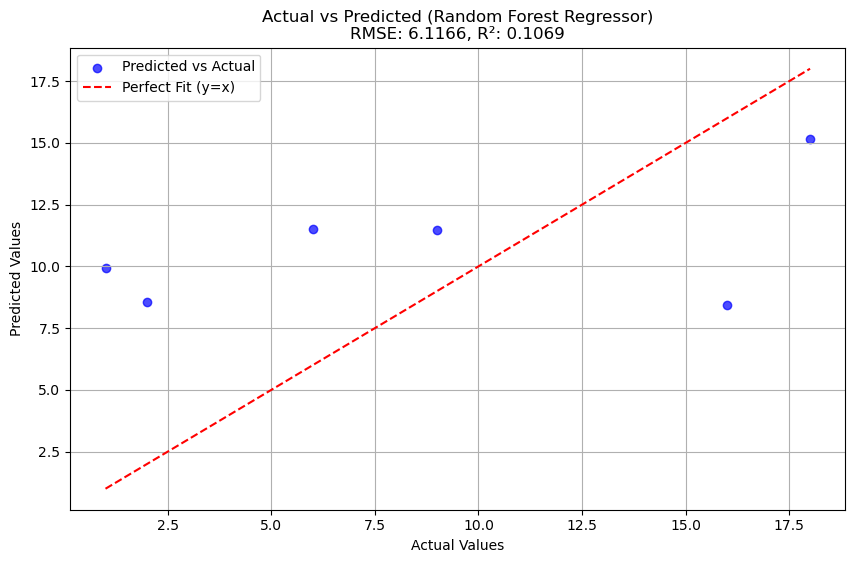

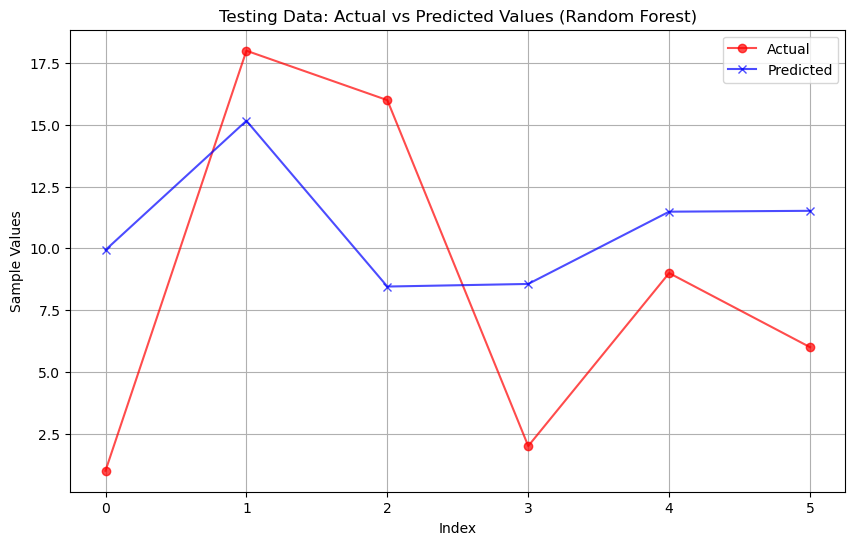

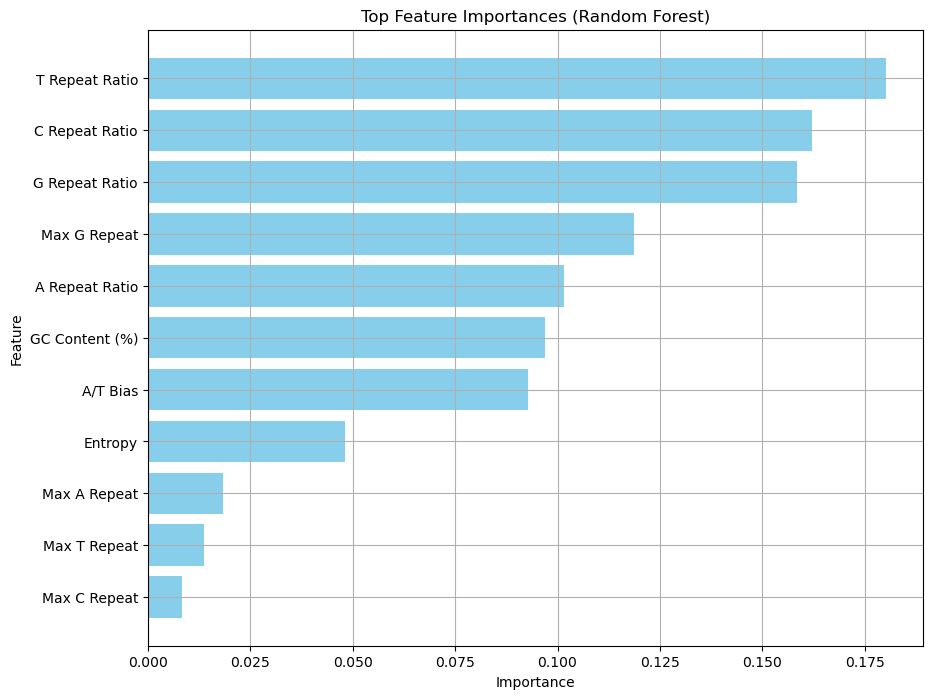

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Calculate evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print results
print(f"Best Parameters: {rf_grid_search.best_params_}")
print(f"Random Forest Regressor (GridSearchCV) - RMSE: {rmse_rf:.4f}, R² Score: {r2_rf:.4f}")

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color="blue", label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit (y=x)")
plt.title(f'Actual vs Predicted (Random Forest Regressor)\nRMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

# Extract feature importances and sort them
feature_importances = best_rf_model.named_steps['model'].feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature {i}" for i in range(X_train.shape[1])]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Limit to Top-N features
top_n = min(len(importance_df), 20)  # Top-N features (default 20, but limited by total features)
top_features = importance_df.head(top_n)

# Line Plot: Actual vs Predicted Values for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", color="red", alpha=0.7, linewidth=1.5, marker='o')
plt.plot(range(len(y_pred_rf)), y_pred_rf, label="Predicted", color="blue", alpha=0.7, linewidth=1.5, marker='x')
plt.title("Testing Data: Actual vs Predicted Values (Random Forest)")
plt.xlabel("Index")
plt.ylabel("Sample Values")
plt.legend()
plt.grid()
plt.show()

# Bar Plot: Feature Importances
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color="skyblue")
plt.title('Top Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Reverse the order for better visualization
plt.grid()
plt.show()


## 4 Gradient Boosting Model (GBM)


In [ ]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from lightgbm import LGBMRegressor
# from sklearn.impute import SimpleImputer
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import GridSearchCV
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # 将 numpy 数组转换为 DataFrame（如果需要）
# X_train = pd.DataFrame(X_train, columns=X.columns if isinstance(X, pd.DataFrame) else [f"Feature {i}" for i in range(X.shape[1])])
# X_test = pd.DataFrame(X_test, columns=X.columns if isinstance(X, pd.DataFrame) else [f"Feature {i}" for i in range(X.shape[1])])

# # 转换布尔类型为整数
# X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include=['bool']).columns})
# X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(include=['bool']).columns})

# # 使用均值插补缺失值
# imputer = SimpleImputer(strategy='mean')
# X_train = imputer.fit_transform(X_train)
# X_test = imputer.transform(X_test)

# # 确保目标变量的形状是一维
# y_train = y_train.ravel()

# # 定义参数网格
# param_grid = {
#     'n_estimators': [100, 200,],
#     'learning_rate': [ 0.05, 0.1],
#     'max_depth': [3, 4]
# }


# # 初始化 LightGBM 模型
# lgbm = LGBMRegressor(random_state=42, device='cpu', verbose=-1)  # 设置详细日志

# # 使用 GridSearchCV 进行超参数调优
# grid_search = GridSearchCV(
#     estimator=lgbm,               # 模型
#     param_grid=param_grid,        # 参数网格
#     cv=3,                         # 交叉验证折数
#     scoring='neg_mean_squared_error',  # 评估指标
#     verbose=1,                    # 输出详细信息
#     n_jobs=1                     # 并行计算
# )
# grid_search.fit(X_train, y_train)

# # 获取最佳模型和参数
# best_model = grid_search.best_estimator_
# print(f"Best Parameters: {grid_search.best_params_}")

# # 在测试集上进行预测并评估模型
# y_pred = best_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# rmse_gbm = np.sqrt(mse)
# r2_gbm = r2_score(y_test, y_pred)

# print(f"Tuned LightGBM - RMSE: {rmse_gbm:.4f}, R²: {r2_gbm:.4f}")

# # 可视化实际值与预测值的散点图
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predicted vs Actual")
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit (y=x)")
# plt.title(f'Actual vs Predicted (LightGBM Regressor)\nRMSE: {rmse_gbm:.4f}, R²: {r2_gbm:.4f}')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.legend()
# plt.grid()
# plt.show()

# # 折线图：实际值与预测值
# plt.figure(figsize=(10, 6))
# plt.plot(range(len(y_test)), y_test, label="Actual", color="red", marker='o', alpha=0.7, linewidth=1.5)
# plt.plot(range(len(y_pred)), y_pred, label="Predicted", color="blue", marker='x', alpha=0.7, linewidth=1.5)
# plt.title("Testing Data: Actual vs Predicted Values (LightGBM)")
# plt.xlabel("Index")
# plt.ylabel("Sample Values")
# plt.legend()
# plt.grid()
# plt.show()

# # 提取特征重要性
# feature_importances = best_model.feature_importances_
# feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"Feature {i}" for i in range(X.shape[1])]

# # 可视化特征重要性
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# # Bar Plot: Feature Importances
# plt.figure(figsize=(10, 8))
# plt.barh(importance_df['Feature'], importance_df['Importance'], color="skyblue")
# plt.title('Feature Importances (LightGBM)')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.gca().invert_yaxis()
# plt.grid()
# plt.show()


# 5 SVM Model


开始训练 SVM 模型...
SVM 模型训练完成！
Best SVM Parameters: {'kernel': 'poly', 'epsilon': 0.1, 'C': 0.21544346900318834}
SVM RMSE: 6.9700
SVM R²: -0.1598


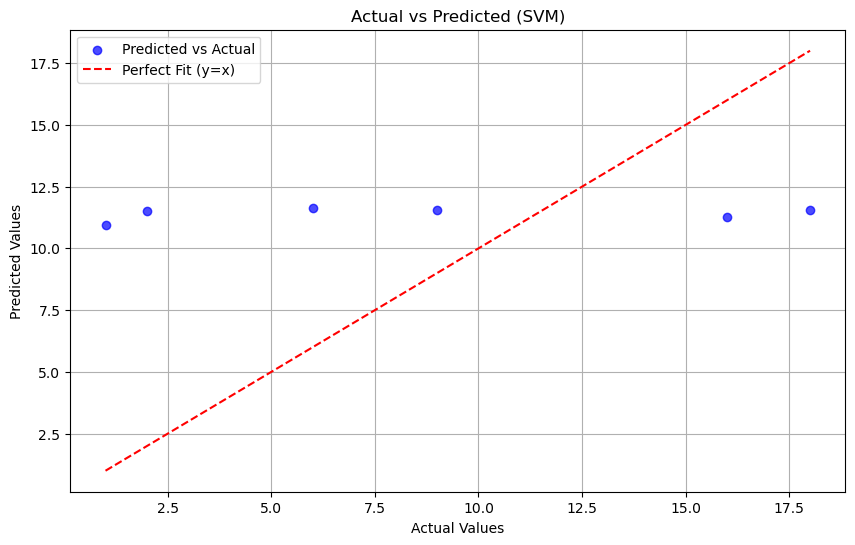

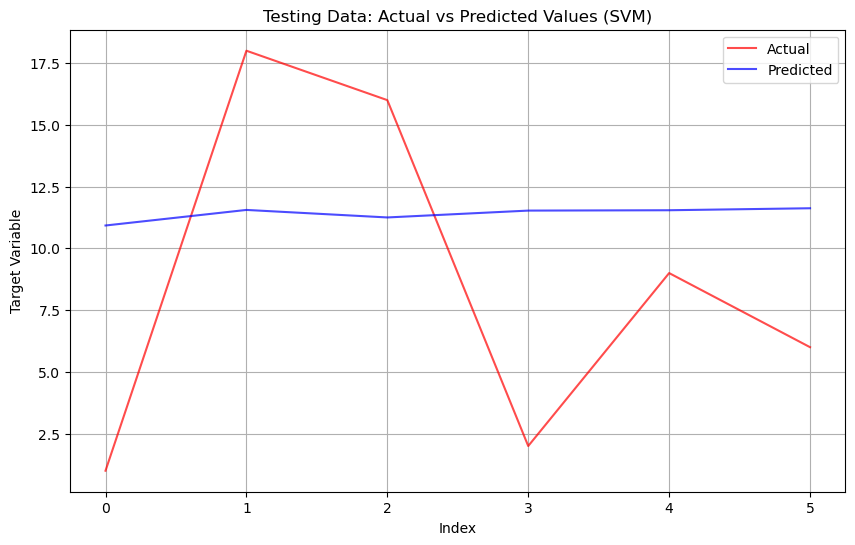

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 预处理：标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA 降维
pca = PCA(n_components=0.95)  # 保留95%的方差
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 定义 SVM 超参数搜索范围
svm_param_dist = {
    'kernel': ['linear', 'poly', 'rbf'],  # 核函数类型
    'C': np.logspace(-1, 2, 10),         # 正则化参数
    'epsilon': [0.1, 0.2, 0.5]           # 回归松弛范围
}

# 随机搜索调参
svm_random = RandomizedSearchCV(
    SVR(), 
    param_distributions=svm_param_dist, 
    n_iter=10,                          # 搜索次数
    cv=3,                               # 交叉验证
    scoring='neg_mean_squared_error',   # 评分方式
    random_state=42, 
    n_jobs=-1                           # 并行计算
)

# 模型训练
print("开始训练 SVM 模型...")
svm_random.fit(X_train_pca, y_train)
print("SVM 模型训练完成！")

# 最佳参数
best_svm_params = svm_random.best_params_
print(f"Best SVM Parameters: {best_svm_params}")

# 在测试集上预测
y_pred_svm = svm_random.best_estimator_.predict(X_test_pca)

# 计算评估指标
rmse_svm = mean_squared_error(y_test, y_pred_svm, squared=False)
r2_svm = r2_score(y_test, y_pred_svm)

print(f"SVM RMSE: {rmse_svm:.4f}")
print(f"SVM R²: {r2_svm:.4f}")

# 可视化实际值与预测值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svm, alpha=0.7, color="blue", label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit (y=x)")
plt.title('Actual vs Predicted (SVM)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

# 折线图：实际值与预测值
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", color="red", alpha=0.7, linewidth=1.5)
plt.plot(range(len(y_pred_svm)), y_pred_svm, label="Predicted", color="blue", alpha=0.7, linewidth=1.5)
plt.title("Testing Data: Actual vs Predicted Values (SVM)")
plt.xlabel("Index")
plt.ylabel("Target Variable")
plt.legend()
plt.grid()
plt.show()


# 6 KNN Model


开始训练 KNN 模型...


/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://g

KNN 模型训练完成！
Best KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
KNN RMSE: 6.8737
KNN R²: -0.1279


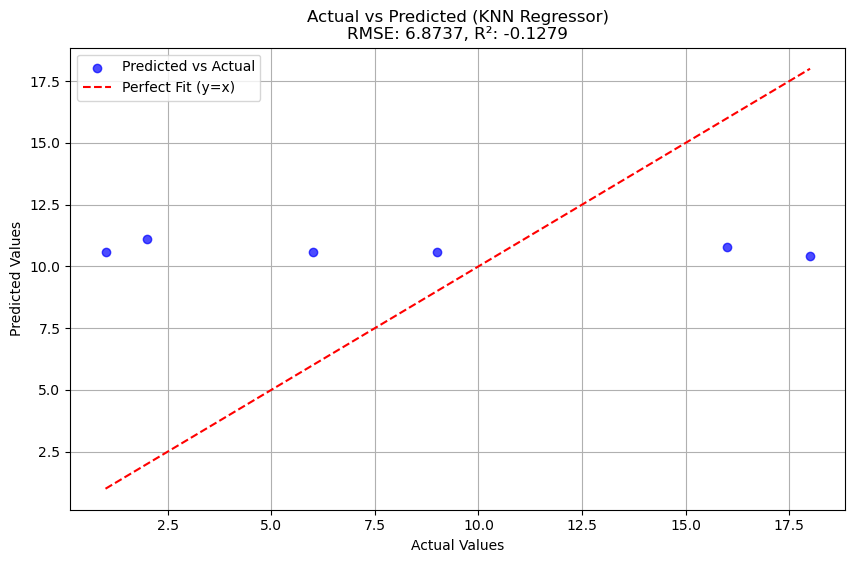

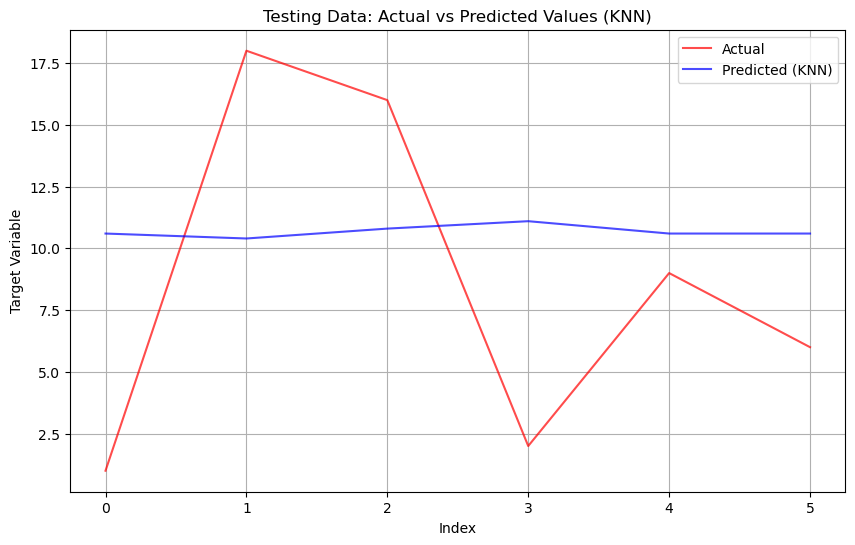

Final Results:
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
RMSE: 6.8737
R²: -0.1279


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义 KNN 参数网格
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10],            # 邻居数
    'weights': ['uniform', 'distance'],      # 权重方式
    'metric': ['euclidean', 'manhattan']     # 距离度量
}

# 使用 GridSearchCV 进行超参数调优
knn_grid = GridSearchCV(
    KNeighborsRegressor(), 
    param_grid=knn_param_grid, 
    cv=5,                                     # 5 折交叉验证
    scoring='neg_mean_squared_error',         # 评分指标
    n_jobs=-1                                 # 并行计算
)

print("开始训练 KNN 模型...")
knn_grid.fit(X_train_scaled, y_train)
print("KNN 模型训练完成！")

# 最佳参数
best_knn_params = knn_grid.best_params_
print(f"Best KNN Parameters: {best_knn_params}")

# 在测试集上预测
y_pred_knn = knn_grid.best_estimator_.predict(X_test_scaled)

# 计算评估指标
rmse_knn = mean_squared_error(y_test, y_pred_knn, squared=False)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN RMSE: {rmse_knn:.4f}")
print(f"KNN R²: {r2_knn:.4f}")

# 可视化实际值与预测值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.7, color="blue", label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit (y=x)")
plt.title(f'Actual vs Predicted (KNN Regressor)\nRMSE: {rmse_knn:.4f}, R²: {r2_knn:.4f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

# 折线图：实际值与预测值
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", color="red", alpha=0.7, linewidth=1.5)
plt.plot(range(len(y_pred_knn)), y_pred_knn, label="Predicted (KNN)", color="blue", alpha=0.7, linewidth=1.5)
plt.title("Testing Data: Actual vs Predicted Values (KNN)")
plt.xlabel("Index")
plt.ylabel("Target Variable")
plt.legend()
plt.grid()
plt.show()

# 输出最佳参数、RMSE 和 R² 值
print(f"Final Results:\nBest Parameters: {best_knn_params}\nRMSE: {rmse_knn:.4f}\nR²: {r2_knn:.4f}")


Best Alpha (Regularization Strength): 10
Root Mean Squared Error (RMSE): 6.9820
R² Score: -0.1638


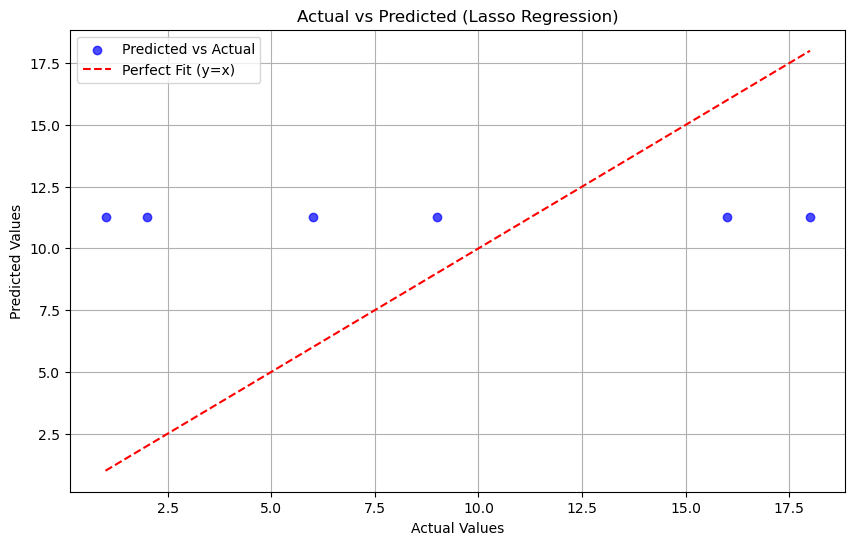

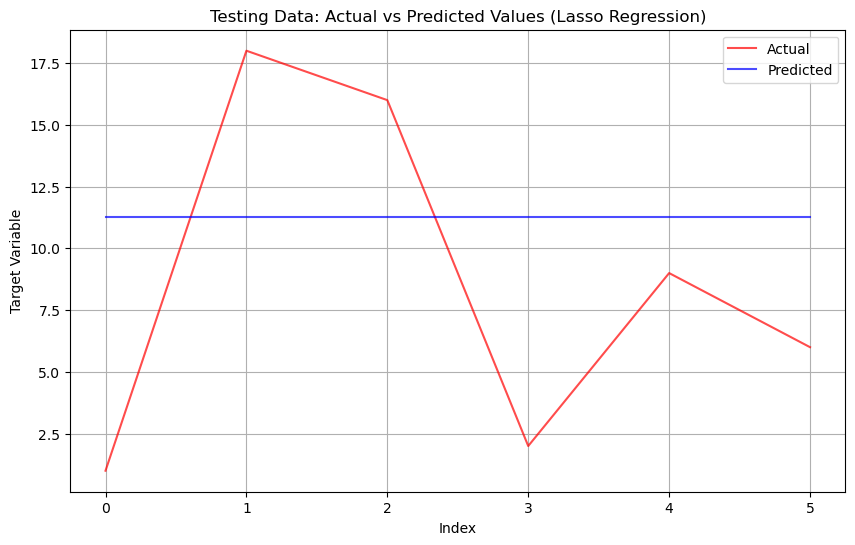

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a pipeline: scaling + Lasso Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('lasso', Lasso(max_iter=10000))  
])

# Define the hyperparameter grid for alpha
param_grid = {
    'lasso__alpha': [0.01, 0.1, 1, 10, 50, 100]
}

# Set up GridSearchCV for hyperparameter tuning
lasso_grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

# Best alpha value
best_alpha = lasso_grid.best_params_['lasso__alpha']
print(f"Best Alpha (Regularization Strength): {best_alpha}")

# Predict on the test set using the best Lasso model
y_pred = lasso_grid.best_estimator_.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse_lasso = np.sqrt(mse)
r2_lasso = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse_lasso:.4f}")
print(f"R² Score: {r2_lasso:.4f}")

# Scatter plot: Actual vs Predicted for Lasso Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b', label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit (y=x)")
plt.title('Actual vs Predicted (Lasso Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

# Plot: Actual vs Predicted values 
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", color="red", alpha=0.7, linewidth=1.5)
plt.plot(range(len(y_pred)), y_pred, label="Predicted", color="blue", alpha=0.7, linewidth=1.5)
plt.title("Testing Data: Actual vs Predicted Values (Lasso Regression)")
plt.xlabel("Index")
plt.ylabel("Target Variable")
plt.legend()
plt.grid()
plt.show()


# 7 Neural Network


开始训练神经网络模型...


/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  war

神经网络模型训练完成！
Best Neural Network Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}
Neural Network RMSE: 6.3447
Neural Network R²: 0.0390


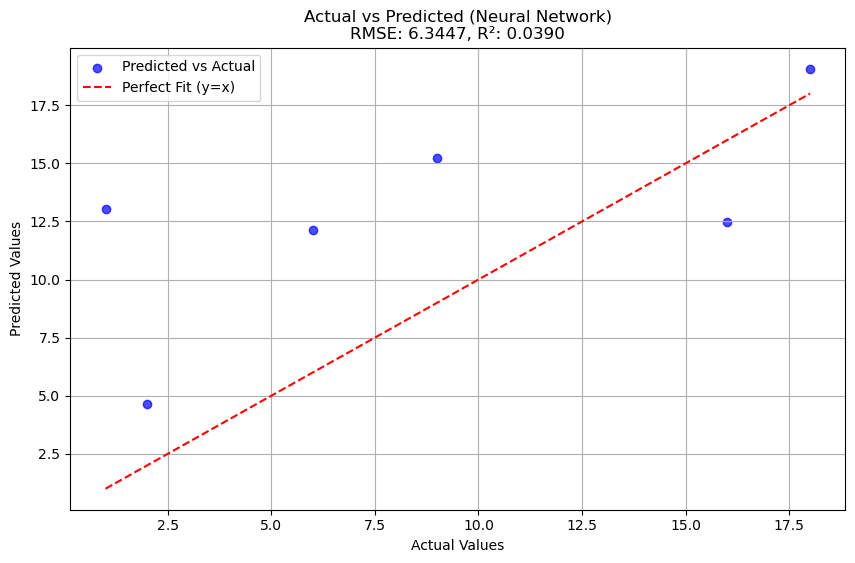

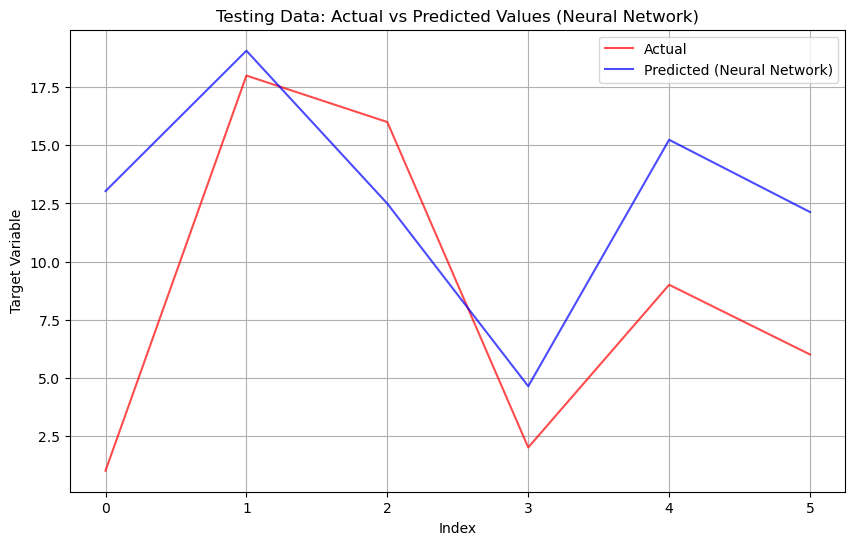

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 定义神经网络的参数网格
nn_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],  # 隐藏层结构
    'activation': ['relu', 'tanh'],                   # 激活函数
    'solver': ['adam', 'sgd'],                        # 优化器
    'alpha': [0.0001, 0.001, 0.01]                    # L2正则化系数
}

# 使用 GridSearchCV 对神经网络进行超参数调优
print("开始训练神经网络模型...")
nn_grid = GridSearchCV(
    MLPRegressor(max_iter=500, random_state=42),  # 最大迭代次数设置为 500
    param_grid=nn_param_grid, 
    cv=5,                                        # 5 折交叉验证
    scoring='neg_mean_squared_error',            # 使用负均方误差作为评分标准
    n_jobs=-1                                    # 并行计算
)
nn_grid.fit(X_train_scaled, y_train)
print("神经网络模型训练完成！")

# 最佳参数
best_nn_params = nn_grid.best_params_
print(f"Best Neural Network Parameters: {best_nn_params}")

# 使用最佳模型预测测试集
y_pred_nn = nn_grid.best_estimator_.predict(X_test_scaled)

# 计算评估指标
rmse_nn = mean_squared_error(y_test, y_pred_nn, squared=False)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network RMSE: {rmse_nn:.4f}")
print(f"Neural Network R²: {r2_nn:.4f}")

# 可视化实际值与预测值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.7, color="blue", label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit (y=x)")
plt.title(f'Actual vs Predicted (Neural Network)\nRMSE: {rmse_nn:.4f}, R²: {r2_nn:.4f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

# 折线图：实际值与预测值
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", color="red", alpha=0.7, linewidth=1.5)
plt.plot(range(len(y_pred_nn)), y_pred_nn, label="Predicted (Neural Network)", color="blue", alpha=0.7, linewidth=1.5)
plt.title("Testing Data: Actual vs Predicted Values (Neural Network)")
plt.xlabel("Index")
plt.ylabel("Target Variable")
plt.legend()
plt.grid()
plt.show()


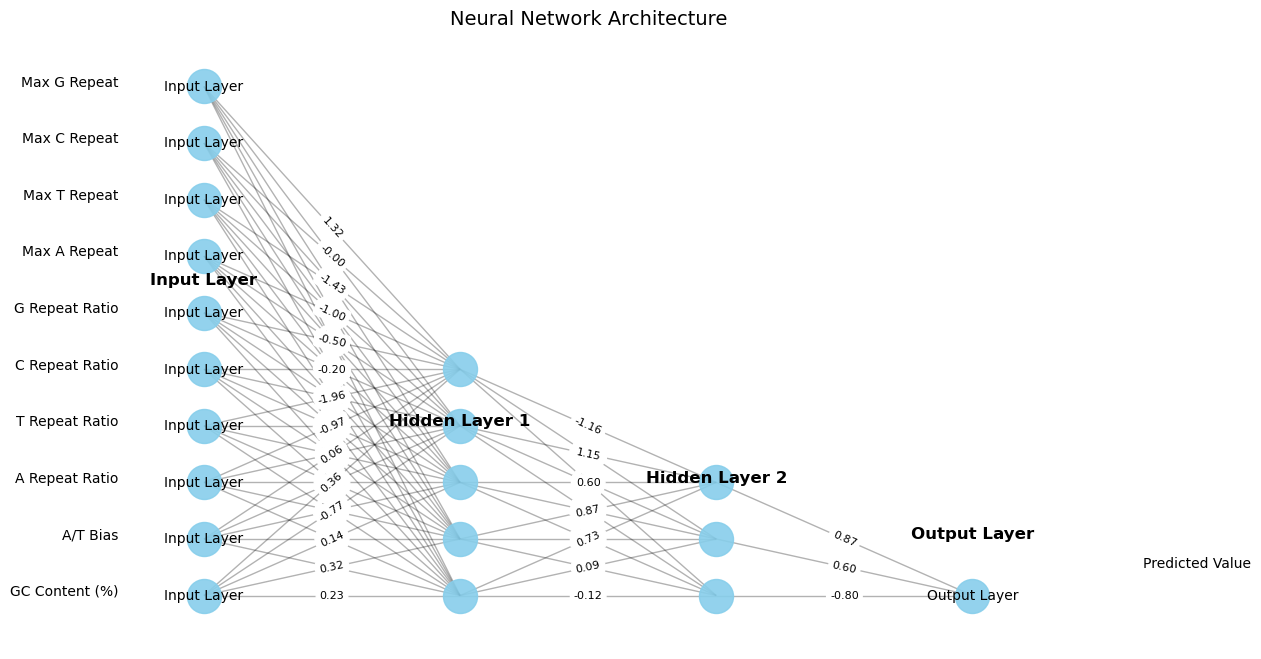

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 定义特征名（替换为您提取的特征名）
input_features = [
    "GC Content (%)", 
    "A/T Bias", 
    "A Repeat Ratio", 
    "T Repeat Ratio", 
    "C Repeat Ratio", 
    "G Repeat Ratio", 
    "Max A Repeat", 
    "Max T Repeat", 
    "Max C Repeat", 
    "Max G Repeat"
]

# 模拟权重矩阵（请替换为真实权重）
n_input = len(input_features)
n_hidden1 = 5  # 第一隐藏层神经元个数
n_hidden2 = 3  # 第二隐藏层神经元个数
n_output = 1   # 输出层神经元个数

input_to_hidden1_weights = np.random.randn(n_input, n_hidden1)  
hidden1_to_hidden2_weights = np.random.randn(n_hidden1, n_hidden2)  
hidden2_to_output_weights = np.random.randn(n_hidden2, n_output) 

weights = [input_to_hidden1_weights, hidden1_to_hidden2_weights, hidden2_to_output_weights]

# 神经网络层设置
layers = [
    {'neurons': n_input, 'label': 'Input Layer'},
    {'neurons': n_hidden1, 'label': 'Hidden Layer 1'},
    {'neurons': n_hidden2, 'label': 'Hidden Layer 2'},
    {'neurons': n_output, 'label': 'Output Layer'}
]

# 创建神经网络图
G = nx.DiGraph()
positions = {}
y_offset = 2
x_offset = 3
node_labels = {}
edge_labels = {}

for i, layer in enumerate(layers):
    for j in range(layer['neurons']):
        node_name = f'{layer["label"]}_{j+1}'
        G.add_node(node_name, layer=layer['label'])
        positions[node_name] = (i * x_offset, j * y_offset)
        node_labels[node_name] = layer['label'] if i == 0 or i == len(layers) - 1 else ''

        # 连接前一层的神经元
        if i > 0:
            prev_layer = layers[i - 1]
            for k in range(prev_layer['neurons']):
                prev_node_name = f'{prev_layer["label"]}_{k+1}'
                G.add_edge(prev_node_name, node_name)

                # 添加权重并检查索引是否越界
                if i - 1 < len(weights) and k < weights[i - 1].shape[0] and j < weights[i - 1].shape[1]:
                    edge_weight = weights[i - 1][k, j]
                else:
                    edge_weight = 0  # 如果索引超出范围，设置为0
                edge_labels[(prev_node_name, node_name)] = f'{edge_weight:.2f}'

# 绘制神经网络
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, positions, node_size=600, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(G, positions, arrows=False, alpha=0.3)
nx.draw_networkx_labels(G, positions, labels=node_labels, font_size=10)

# 添加层标签
for i, layer in enumerate(layers):
    x_position = i * x_offset
    y_position = (layer['neurons'] - 1) * y_offset / 2
    plt.text(x_position, y_position + 2, layer['label'], fontsize=12, ha='center', fontweight='bold')

# 添加特征名和输出标签
for i, feature in enumerate(input_features):
    plt.text(-1, i * y_offset, feature, fontsize=10, ha='right')
plt.text(len(layers) * x_offset - 1, y_offset / 2, "Predicted Value", fontsize=10, ha='left')

# 绘制边权重
nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels, font_size=8, label_pos=0.5)

plt.title('Neural Network Architecture', fontsize=14)
plt.axis('off')
plt.show()


In [ ]:
print(rmse_lasso, rmse_rf, rmse_svm, rmse_knn, rmse_nn)


6.981998232578399 6.11661262464773 6.9700413725170876 6.873742309203433 6.344726614597931


Model Performance Comparison:
           Model     RMSE        R²
Lasso Regression 6.981998 -0.163753
   Random Forest 6.116613  0.106853
             SVM 6.970041 -0.159770
             KNN 6.873742 -0.127944
  Neural Network 6.344727  0.038992


/var/folders/tx/xqtj99597b1g3xwmxgm3lrsh0000gn/T/ipykernel_51221/2173118576.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df, palette='Blues_d')


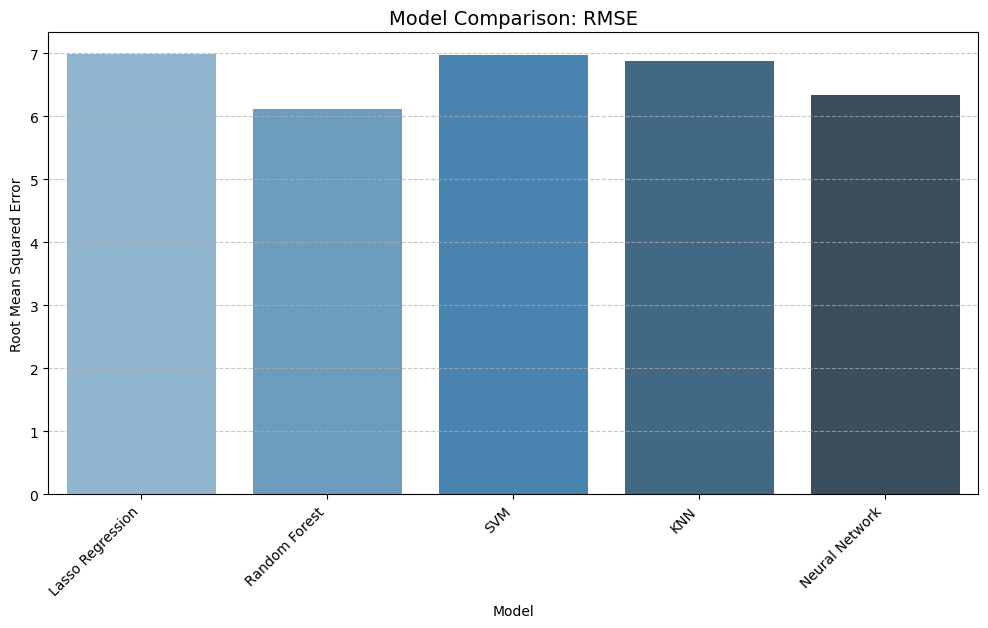

/var/folders/tx/xqtj99597b1g3xwmxgm3lrsh0000gn/T/ipykernel_51221/2173118576.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R²', data=results_df, palette='Greens_d')


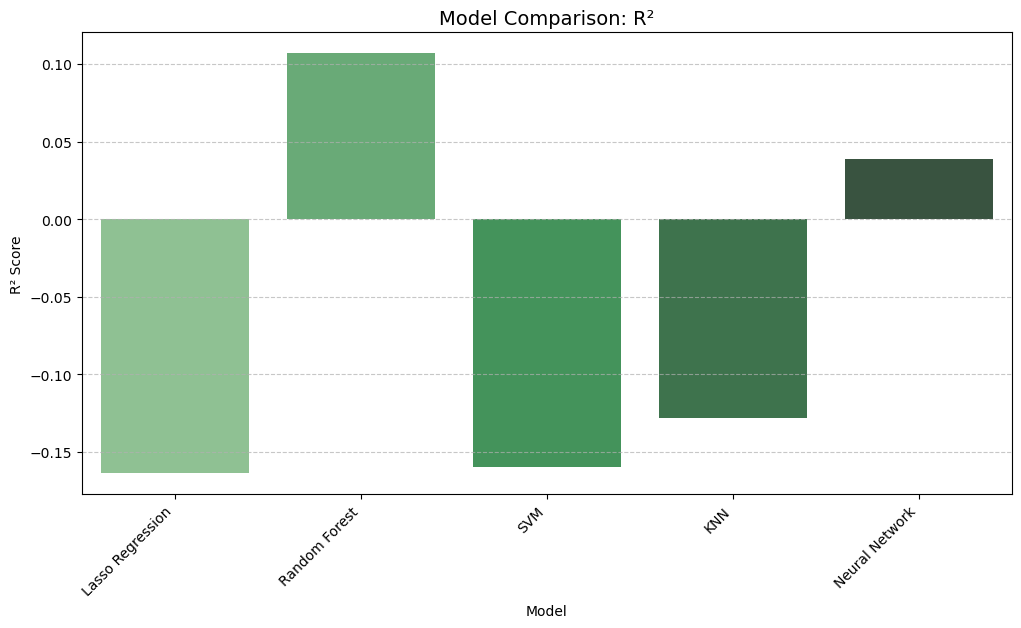

In [ ]:
# 汇总模型结果
model_results = {
    'Model': ['Lasso Regression', 'Random Forest', 'SVM', 'KNN', 'Neural Network'],
    'RMSE': [rmse_lasso, rmse_rf, rmse_svm, rmse_knn, rmse_nn],
    'R²': [r2_lasso, r2_rf, r2_svm, r2_knn, r2_nn]
}

results_df = pd.DataFrame(model_results)

# 打印结果表格
print("Model Performance Comparison:")
print(results_df.to_string(index=False))

# 可视化 RMSE
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=results_df, palette='Blues_d')
plt.title('Model Comparison: RMSE', fontsize=14)
plt.ylabel('Root Mean Squared Error')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 可视化 R²
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R²', data=results_df, palette='Greens_d')
plt.title('Model Comparison: R²', fontsize=14)
plt.ylabel('R² Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
